# Deep Learning for Predictive Maintenance

Deep learning has proven to show superior performance in certain domains such as object recognition and image classification. It has also gained popularity in  domains such as finance where time-series data plays an important role. Predictive Maintenance is also a domain where data is collected over time to monitor the state of an asset with the goal of finding patterns to predict failures which can also benefit from certain deep learning algorithms. Among the deep learning methods, Long Short Term Memory [(LSTM)](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) networks are especially appealing to the predictive maintenance domain due to the fact that they are very good at learning from sequences. This fact lends itself to their applications using time series data by making it possible to look back for longer periods of time to detect failure patterns. In this notebook, we build an LSTM network for the data set and scenerio described at [Predictive Maintenance Template](https://gallery.cortanaintelligence.com/Collection/Predictive-Maintenance-Template-3) to predict remaining useful life of aircraft engines. In summary, the template uses simulated aircraft sensor values to predict when an aircraft engine will fail in the future so that maintenance can be planned in advance. 

This notebook serves as a tutorial for beginners looking to apply deep learning in predictive maintenance domain and uses a simple scenario where only one data source (sensor values) is used to make predictions. In more advanced predictive maintenance scenarios such as in [Predictive Maintenance Modelling Guide](https://gallery.cortanaintelligence.com/Notebook/Predictive-Maintenance-Modelling-Guide-R-Notebook-1), there are many other data sources (i.e. historical maintenance records, error logs, machine and operator features etc.) which may require different types of treatments to be used in the deep learning networks. Since predictive maintenance is not a typical domain for deep learning, its application is an open area of research.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation

In [2]:
# Setting seed for reproducability
np.random.seed(1234)  
PYTHONHASHSEED = 0

## Data Ingestion

In the following section, we ingest the training, test and ground truth datasets from azure storage. The training data consists of multiple multivariate time series with "cycle" as the time unit, together with 21 sensor readings for each cycle. Each time series can be assumed as being generated from a different engine of the same type. The testing data has the same data schema as the training data. The only difference is that the data does not indicate when the failure occurs. Finally, the ground truth data provides the number of remaining working cycles for the engines in the testing data. You can find more details about the type of data used for this notebook at [Predictive Maintenance Template](https://gallery.cortanaintelligence.com/Collection/Predictive-Maintenance-Template-3).


In [3]:
# Downloading the datasets from Azure blob

from pathlib import Path
import requests

data_path = Path("data")
data_path.mkdir(parents=True, exist_ok=True)

url = "http://azuremlsamples.azureml.net/templatedata/"
filenames = ["PM_train.txt", "PM_test.txt", "PM_truth.txt"]

for filename in filenames:
    if not (data_path / filename).exists():
        content = requests.get(url + filename).content
        (data_path / filename).open("wb").write(content)

Let's load the dataset into Pandas' DataFrame.

In [4]:
# read training data 
train_df = pd.read_csv('data/PM_train.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3'] + ['s' + str(i) for i in range(1, 22)]

# read test data
test_df = pd.read_csv('data/PM_test.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3'] + ['s' + str(i) for i in range(1, 22)]

# read ground truth data
truth_df = pd.read_csv('data/PM_truth.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1

In [5]:
train_df = train_df.sort_values(['id','cycle'])
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


## Data Preprocessing

First step is to generate labels for the training data which are ``rul`` (Remaining Useful Life), ``label1`` and ``label2`` as was done in the [Predictive Maintenance Template](https://gallery.cortanaintelligence.com/Collection/Predictive-Maintenance-Template-3). Here, we will only make use of ``label1`` for binary clasification, while trying to answer the question: "Is a specific engine going to fail within ``w1`` cycles?"


In [6]:
# generate column `rul` (Remaining Useful Life)
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['rul'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [7]:
# generate column `rul` for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['rul'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,142
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,141
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,140
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,139
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,138


Data Labeling
-------------

Based on the input data description, an intuitive predictive maintenance question to ask is "Given these aircraft engine operation and failure events history, can we predict when an in-service engine will fail?"

We re-formulate this question into three closely relevant questions and answer them using three different types of machine learning models. While we go through all three questions, likely only one would be chosen in practice depending on the business requirements.

- Regression models: How many more cycles an in-service engine will last before it fails?
- Binary classification: Is this engine going to fail within ``w1`` cycles?
- Multi-class classification: Is this engine going to fail within the window ``[1, w0]`` cycles or to fail within the window ``[w0+1, w1]`` cycles, or it will not fail within ``w1`` cycles?

In [8]:
# Generate label columns for training data
w0 = 15
w1 = 30
# `label1`: for Binary classification
train_df['label1'] = np.where(train_df['rul'] <= w1, 1, 0 )
# `label2`: for Multi-class classification
train_df['label2'] = train_df['label1']
train_df.loc[train_df['rul'] <= w0, 'label2'] = 2

train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,rul,label1,label2
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0,0


In [9]:
# generate label columns for test data
test_df['label1'] = np.where(test_df['rul'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['rul'] <= w0, 'label2'] = 2
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,rul,label1,label2
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8.4052,0.03,392,2388,100.0,38.86,23.3735,142,0,0
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8.3803,0.03,393,2388,100.0,39.02,23.3916,141,0,0
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8.4441,0.03,393,2388,100.0,39.08,23.4166,140,0,0
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8.3917,0.03,391,2388,100.0,39.00,23.3737,139,0,0
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8.4031,0.03,390,2388,100.0,38.99,23.4130,138,0,0


In the [Predictive Maintenance Template](https://gallery.cortanaintelligence.com/Collection/Predictive-Maintenance-Template-3) , cycle column is also used for training so we will also include the cycle column. Here, we normalize the columns in the training data.


In [10]:
# MinMax normalization
train_df['cycle_norm'] = train_df['cycle']
# Remaining columns after excluding `['id','cycle','rul','label1','label2']` columns
cols_normalize = train_df.columns.difference(['id','cycle','rul','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
# A new DataFrame from normalized columns, excluding `['id','cycle','rul','label1','label2']` columns
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
# Combine normalized columns with `['id','cycle','rul','label1','label2']` columns
# Note: `columns.difference` is applied twice
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,rul,label1,label2,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0,0.00554
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0,0.00831
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0,0.01108


Next, we prepare the test data. We first normalize the test data using the parameters from the MinMax normalization applied on the training data.


In [11]:
test_df['cycle_norm'] = test_df['cycle']
# Unlike training data, we only apply `transform` to test data instead of `fit_transform`
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,rul,label1,label2,cycle_norm
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.0,0.333333,0.0,0.0,0.558140,0.661834,142,0,0,0.00000
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.0,0.416667,0.0,0.0,0.682171,0.686827,141,0,0,0.00277
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.0,0.416667,0.0,0.0,0.728682,0.721348,140,0,0,0.00554
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.0,0.250000,0.0,0.0,0.666667,0.662110,139,0,0,0.00831
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.0,0.166667,0.0,0.0,0.658915,0.716377,138,0,0,0.01108


In the rest of the notebook, we train an LSTM network that we will compare to the results in [Predictive Maintenance Template Step 2B of 3](https://gallery.cortanaintelligence.com/Experiment/Predictive-Maintenance-Step-2B-of-3-train-and-evaluate-binary-classification-models-2) where a series of machine learning models are used to train and evaluate the binary classification model that uses column ``label1`` as the label.


## Modelling

The traditional predictive maintenance machine learning models are based on feature engineering which is manual construction of right features using domain expertise and similar methods. This usually makes these models hard to reuse since feature engineering is specific to the problem scenario and the available data which varies from one business to the other. Perhaps the most attractive part of applying deep learning in the predictive maintenance domain is the fact that these networks can automatically extract the right features from the data, eliminating the need for manual feature engineering.

When using LSTMs in the time-series domain, one important parameter to pick is the sequence length which is the window for LSTMs to look back. This may be viewed as similar to picking ``window_size = 5`` cycles for calculating the rolling features in the [Predictive Maintenance Template](https://gallery.cortanaintelligence.com/Collection/Predictive-Maintenance-Template-3) which are rolling mean and rolling standard deviation for 21 sensor values. The idea of using LSTMs is to let the model extract abstract features out of the sequence of sensor values in the window rather than engineering those manually. The expectation is that if there is a pattern in these sensor values within the window prior to failure, the pattern should be encoded by the LSTM.

One critical advantage of LSTMs is their ability to remember from long-term sequences (window sizes) which is hard to achieve by traditional feature engineering. For example, computing rolling averages over a window size of 50 cycles may lead to loss of information due to smoothing and abstracting of values over such a long period, instead, using all 50 values as input may provide better results. While feature engineering over large window sizes may not make sense, LSTMs are able to use larger window sizes and use all the information in the window as input. Below, we illustrate the approach.

Let's first look at an example of the sensor values 50 cycles prior to the failure for engine ``id`` 3. We will be feeding LSTM network this type of data for each time step for each engine ``id``.


In [12]:
# Preparing test data of engine id 3 for visualizations
engine_id3 = test_df[test_df['id'] == 3]

# Window of `sequence_length=50` cycles prior to a failure point
engine_id3_50cycleWindow = engine_id3[engine_id3['rul'] <= engine_id3['rul'].min() + 50]

cols1 = ['s' + str(i) for i in range(1, 11)]
cols2 = ['s' + str(i) for i in range(11, 22)]
engine_id3_50cycleWindow_cols1 = engine_id3_50cycleWindow[cols1]
engine_id3_50cycleWindow_cols2 = engine_id3_50cycleWindow[cols2]

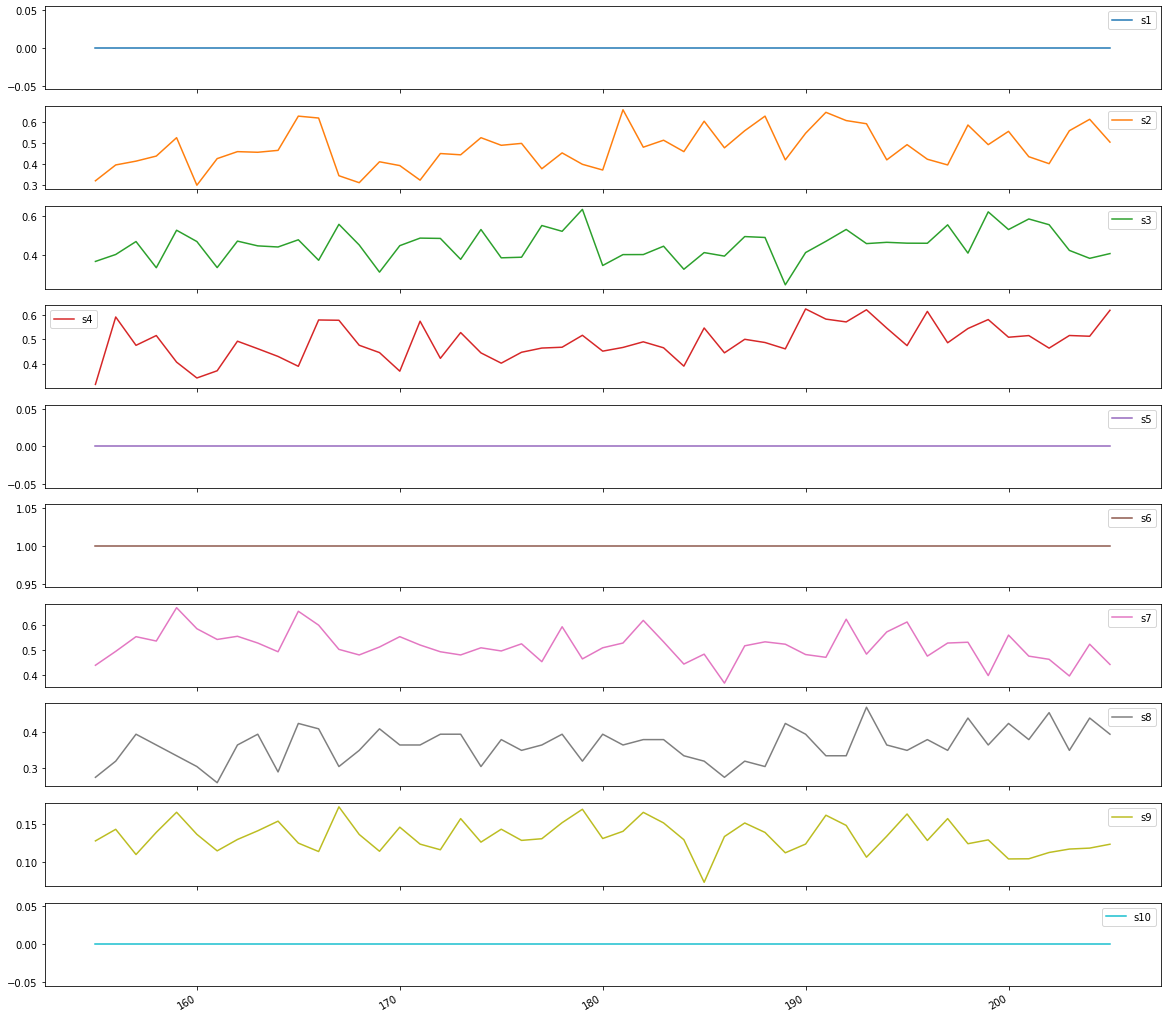

In [13]:
# Plotting sensor data for engine ID 3 prior to a failure point - sensors 1-10 
ax1 = engine_id3_50cycleWindow_cols1.plot(subplots=True, sharex=True, figsize=(20,20))

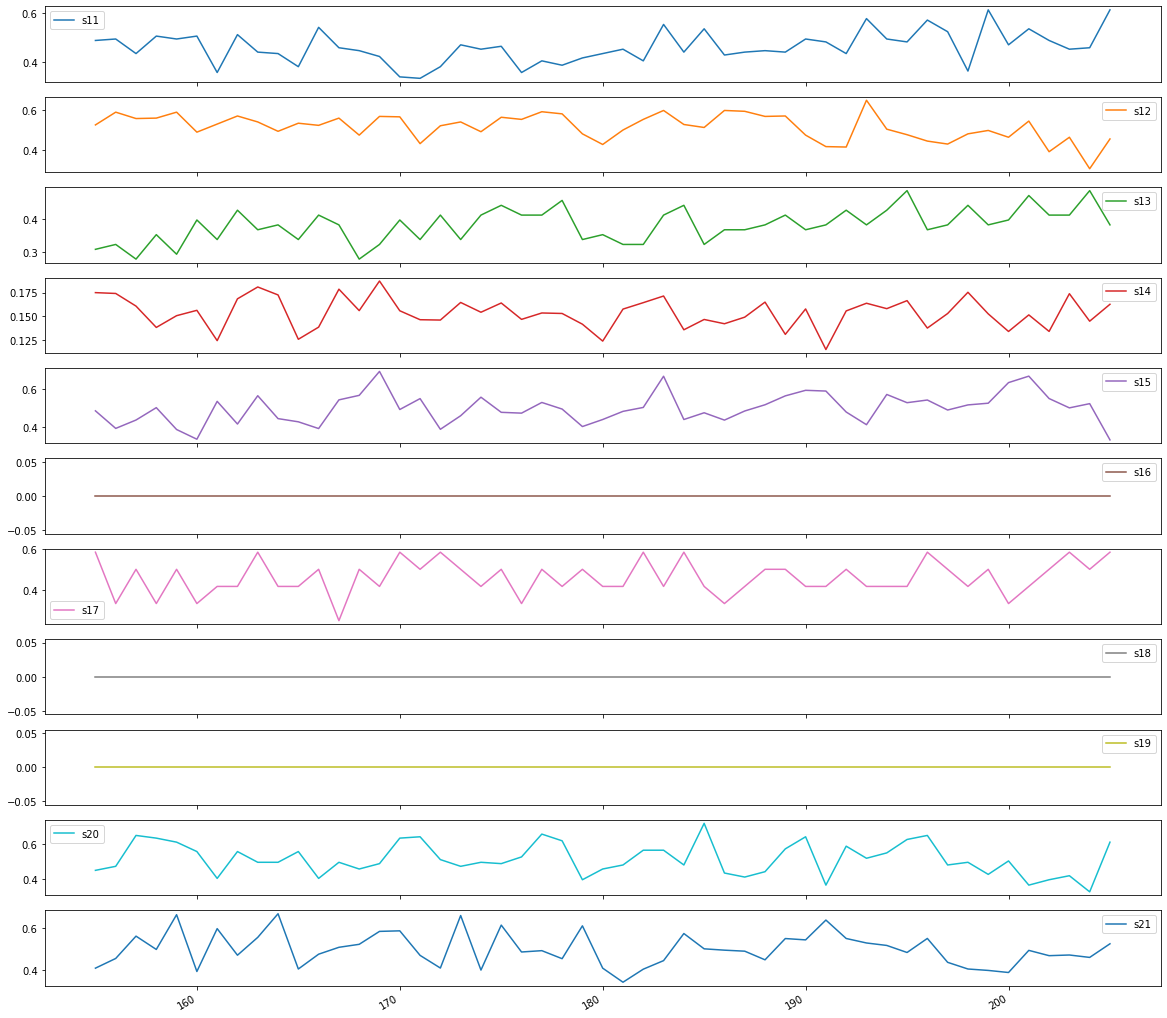

In [14]:
# Plotting sensor data for engine ID 3 prior to a failure point - sensors 11-21 
ax2 = engine_id3_50cycleWindow_cols2.plot(subplots=True, sharex=True, figsize=(20,20))

[Keras LSTM](https://keras.io/api/layers/recurrent_layers/lstm/) layers expect an input in the shape of a numpy array of 3 dimensions (samples, time steps, features) where samples is the number of training sequences, time steps is the look back window or sequence length and features is the number of features of each sequence at each time step.


In [15]:
# Pick a large window size of 50 cycles
sequence_length = 50
# Pick the feature columns and label column
feature_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm'] + ['s' + str(i) for i in range(1, 22)]
label_col = ['label1']

In [16]:
# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, ft_cols):
    """
    Only sequences that meet the window-length are considered, no padding is used.
    This means for testing we need to drop those which are below the window-length.
    An alternative would be to pad sequences so that we can use shorter ones.
    """
    data_array = id_df[ft_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements - seq_length), range(seq_length, num_elements)):
        yield data_array[start: stop, :]

# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length: num_elements, :]

In [17]:
# Generator for the sequences
sequence_generator = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, feature_cols))
                      for id in train_df['id'].unique())
# Generate sequences and convert to numpy array
sequence_array = np.concatenate(list(sequence_generator)).astype(np.float32)
sequence_array.shape

(15631, 50, 25)

In [18]:
# Generator for the labels
label_generator = [gen_labels(train_df[train_df['id']==id], sequence_length, label_col)
                   for id in train_df['id'].unique()]
label_array = np.concatenate(label_generator).astype(np.float32)
label_array.shape

(15631, 1)

## LSTM Network

Next, we build a deep network. The first layer is an LSTM layer with 100 units followed by another LSTM layer with 50 units. Dropout is also applied after each LSTM layer to control overfitting. Final layer is a Dense output layer with single unit and sigmoid activation since this is a binary classification problem.


In [19]:
# Build the LSTM network
nb_features = sequence_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential([
    LSTM(input_shape=(sequence_length, nb_features), units=100, return_sequences=True),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=nb_out, activation='sigmoid'),
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 100)           50400     
_________________________________________________________________
dropout (Dropout)            (None, 50, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 80,651
Trainable params: 80,651
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
%%time
# Fit the network
model.fit(sequence_array, label_array, epochs=10, batch_size=200, validation_split=0.05, verbose=1,
          callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])

Epoch 1/10
75/75 [==============================] - 11s 144ms/step - loss: 0.2339 - accuracy: 0.9006 - val_loss: 0.1256 - val_accuracy: 0.9540
Epoch 2/10
75/75 [==============================] - 9s 120ms/step - loss: 0.0960 - accuracy: 0.9607 - val_loss: 0.0740 - val_accuracy: 0.9693
Epoch 3/10
75/75 [==============================] - 9s 125ms/step - loss: 0.0744 - accuracy: 0.9692 - val_loss: 0.0400 - val_accuracy: 0.9872
Epoch 4/10
75/75 [==============================] - 9s 126ms/step - loss: 0.0809 - accuracy: 0.9682 - val_loss: 0.0372 - val_accuracy: 0.9872
Epoch 5/10
75/75 [==============================] - 13s 169ms/step - loss: 0.0704 - accuracy: 0.9722 - val_loss: 0.0486 - val_accuracy: 0.9821
CPU times: user 2min 9s, sys: 57.5 s, total: 3min 6s
Wall time: 54.6 s


In [21]:
# training metrics
scores = model.evaluate(sequence_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

79/79 [==============================] - 5s 63ms/step - loss: 0.0689 - accuracy: 0.9706
Accurracy: 0.9705712795257568


In [22]:
# make predictions and compute confusion matrix
y_pred = (model.predict(sequence_array, verbose=1, batch_size=200) >= 0.5).astype("int32")
y_true = label_array
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
print(cm)

79/79 [==============================] - 6s 75ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[12483    48]
 [  412  2688]]


In [23]:
# compute precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print( 'Precision = ', precision, '\n', 'Recall = ', recall)

Precision =  0.9824561403508771 
 Recall =  0.8670967741935484


Next, we look at the performance on the test data. In the [Predictive Maintenance Template Step 1 of 3](https://gallery.cortanaintelligence.com/Experiment/Predictive-Maintenance-Step-1-of-3-data-preparation-and-feature-engineering-2), only the last cycle data for each engine id in the test data is kept for testing purposes. In order to compare the results to the template, we pick the last sequence for each id in the test data.


In [24]:
sequence_array_test_last = [test_df[test_df['id']==id][feature_cols].values[-sequence_length:]
                            for id in test_df['id'].unique()
                            if len(test_df[test_df['id']==id]) >= sequence_length]
sequence_array_test_last = np.asarray(sequence_array_test_last).astype(np.float32)
print(sequence_array_test_last.shape)

(93, 50, 25)


In [25]:
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]

Similarly, we pick the labels.

In [26]:
label_array_test_last = test_df.groupby('id')['label1'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0], 1).astype(np.float32)
print(label_array_test_last.shape)

(93, 1)


In [27]:
# test metrics
scores_test = model.evaluate(sequence_array_test_last, label_array_test_last, verbose=2)
print('Accurracy: {}'.format(scores_test[1]))

3/3 - 0s - loss: 0.0794 - accuracy: 0.9892
Accurracy: 0.9892473220825195


In [28]:
# make predictions and compute confusion matrix
y_pred_test = (model.predict(sequence_array_test_last) >= 0.5).astype("int32")
y_true_test = label_array_test_last
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true_test, y_pred_test)
print(cm)

Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[68  0]
 [ 1 24]]


In [29]:
# compute Precision and Recall
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print('Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test)

Precision:  1.0 
 Recall:  0.96 
 F1-score: 0.9795918367346939


In [30]:
results_df = pd.DataFrame([[scores_test[1], precision_test, recall_test, f1_test],
                          [0.94, 0.952381, 0.8, 0.869565]],
                         columns = ['Accuracy', 'Precision', 'Recall', 'F1-score'],
                         index = ['LSTM', 'Template Best Model'])
results_df

,Accuracy,Precision,Recall,F1-score
LSTM,0.989247,1.000000,0.96,0.979592
Template Best Model,0.940000,0.952381,0.80,0.869565


Comparing the above test results to the predictive maintenance template, we see that the LSTM results are better than the template. It should be noted that the  data set used here is very small and deep learning models are known to perform superior with large datasets so for a more fair comparison larger datasets should be used.


## Future Directions and Improvements

This tutorial covers the basics of using deep learning in predictive maintenance and many predictive maintenance problems usually involve a variety of data sources that needs to be taken into account when applying deep learning in this domain. Additionally, it is important to tune the models for the right parameters such as window size. Here are some suggestions on future directions on improvements:
- Try different window sizes.
- Try different architectures with different number of layers and nodes.
- Try tuning hyperparmeters of the network.
- Try predicting RUL (regression) such as in  [Predictive Maintenance Template Step 2A of 3](https://gallery.cortanaintelligence.com/Experiment/Predictive-Maintenance-Step-2A-of-3-train-and-evaluate-regression-models-2) and ``label2`` (multi-class classification) such as in [Predictive Maintenance Template Step 2C of 3](https://gallery.cortanaintelligence.com/Experiment/Predictive-Maintenance-Step-2C-of-3-train-and-evaluation-multi-class-classification-models-2).
- Try on larger data sets with more records.
- Try a different problem scenario such as in [Predictive Maintenance Modelling Guide](https://gallery.cortanaintelligence.com/Notebook/Predictive-Maintenance-Modelling-Guide-R-Notebook-1) where multiple other data sources are involved such as maintenance records.
